<h1 style="font-family:Impact,Arial;font-size:30px;">37011 Financial Market Instrument - Autumn 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 2</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37000 JIT" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />


## Import packages


In [1]:
import math
from datetime import date, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data


#### Future


In [2]:
future = pd.read_excel("Crude Oil May 24.xlsx")
future.drop(columns=["Open", "High", "Low", "Adj Close**"], inplace=True)
future.rename(columns={"Close*":"Price"}, inplace=True)
future['Date'] = pd.to_datetime(future['Date'], format='%b %d, %Y')
future['Price'] = future['Price'].astype(float)
future['Volume'] = future['Volume'].apply(lambda x: np.nan if x == '-' else x)
future = future.interpolate(method='linear')
future['Volume'] = future['Volume'].round()
future['Volume'] = future['Volume'].astype(int)
future.sort_values(by='Date', inplace=True)
future.reset_index(drop=True, inplace=True)
future

,Date,Price,Volume
0,2019-03-26,59.94,685988
1,2019-03-27,59.41,732150
2,2019-03-28,59.30,712209
3,2019-03-29,60.14,705559
4,2019-04-01,61.59,670808
...,...,...,...
1256,2024-03-19,83.47,76814
1257,2024-03-20,81.68,351161
1258,2024-03-21,81.07,266860
1259,2024-03-22,80.63,231101


#### Cushing


In [3]:
cushing = pd.read_csv("Cushing_OK_WTI_Spot_Price_FOB.csv", header=4)
initial_column_names = cushing.columns
cushing['Date'] = pd.to_datetime(cushing['Day'], format='%m/%d/%Y')
cushing['Price'] = cushing[initial_column_names[-1]].astype(float)
cushing.drop(columns=initial_column_names, inplace=True)
cushing.sort_values(by='Date', inplace=True)
cushing.reset_index(drop=True, inplace=True)
cushing

,Date,Price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
...,...,...
9624,2024-03-19,84.39
9625,2024-03-20,82.79
9626,2024-03-21,81.99
9627,2024-03-22,81.10


#### Kerosene


In [4]:
kerosene = pd.read_csv("U.S._Gulf_Coast_Kerosene-Type_Jet_Fuel_Spot_Price_FOB.csv", header=4)
initial_column_names = kerosene.columns
kerosene['Date'] = pd.to_datetime(kerosene['Day'], format='%m/%d/%Y')
kerosene['Price'] = kerosene[initial_column_names[-1]].astype(float)
kerosene.drop(columns=initial_column_names, inplace=True)
kerosene.sort_values(by='Date', inplace=True)
kerosene.reset_index(drop=True, inplace=True)
kerosene

,Date,Price
0,1990-04-02,0.550
1,1990-04-03,0.555
2,1990-04-04,0.560
3,1990-04-05,0.540
4,1990-04-06,0.536
...,...,...
8533,2024-03-19,2.671
8534,2024-03-20,2.606
8535,2024-03-21,2.608
8536,2024-03-22,2.582


## Assumption


- For question 1 and 2, only dates that have both spot price and future price will be assessed.
- For question 3, at the end of the maturity, all accounts will be taken out and put into the capital account.
- For question 3b, all of the profit from the daily settlement are NOT taken out of the margin account.


## Question 1


### a.


So as to calculate the optimal hedge, we use:

$$
h = \rho \frac{\sigma _S}{\sigma _F}
$$

As the company want to hedge their purchase from 1/11/2023 to 19/3/2024 (which is 139 days ahead). The $\rho$ and $\sigma$ will be calculated with the change in price of 139 days before 1/11/2023 (which is from 15/06/2023)


#### Setup


In [5]:
total_barrel = 100000
barrel_per_contract = 1000
start_estimate_date = date(2023,6,14)
end_estimate_date = date(2023,11,1)

#### Calculation


In [6]:
spot_price = cushing[(cushing['Date'].dt.date<=end_estimate_date) & (cushing['Date'].dt.date>=start_estimate_date)].reset_index(drop=True)
future_price = future[(future['Date'].dt.date<=end_estimate_date) & (future['Date'].dt.date>=start_estimate_date)][['Date', 'Price']].reset_index(drop=True)
future_price = future_price[future_price['Date'].isin(set(spot_price['Date']))]
spot_price = np.diff(np.array(spot_price['Price']))
future_price = np.diff(np.array(future_price['Price']))
rho = np.corrcoef(spot_price, future_price)[0, 1]
h = rho * np.std(spot_price, ddof=1)/np.std(future_price, ddof=1)
hedged_barrel = h * total_barrel
total_contract = math.ceil(hedged_barrel / barrel_per_contract)
print('Number on contracts that company needs to enter:',total_contract)

Number on contracts that company needs to enter: 98


#### Conclusion


The company will need to enter long position of 98 contracts on November 1st, 2023 and close the position on March 19th, 2024
Mismatch in the maturity

### b.


#### Setup


In [7]:
start_hedging_date = date(2023,11,1)
end_hedging_date = date(2024,3,19)

#### Calculation


In [8]:
future_price_settle = future[(future['Date'].dt.date==end_hedging_date)]['Price'].reset_index(drop=True).at[0]
future_price_in = future[(future['Date'].dt.date==start_hedging_date)]['Price'].reset_index(drop=True).at[0]
value = (future_price_settle-future_price_in)*total_contract*barrel_per_contract
spot_price_settle = cushing[(cushing['Date'].dt.date==end_hedging_date)]['Price'].reset_index(drop=True).at[0]
cost = spot_price_settle*total_barrel - value
print('Payoff from the hedge:', value)
print('Net payment of the company:', cost)

Payoff from the hedge: 296940.0000000001
Net payment of the company: 8142060.0


#### Conclusion


The company will need to pay net payment of: 8142060


### c.


#### Calculation


In [9]:
basis_risk = (spot_price_settle-future_price_settle)*total_contract*barrel_per_contract
print(basis_risk)

90160.00000000016


#### Conclusion


There is basis risk on the hedging outcome. The hedge has succesfully partly protect the company from the increase in price of the oil barrel. As being aware of the increase in price of the barrel, the company entered the future contract. By then, if the price of the barrel increase, the price of the future contract increase as well. This would lead to the reduction in cost of buying in the future for the company by using the payoff received from the hedge.
Maturity and asset missmatch

## Question 2


### a.


So as to calculate the optimal hedge, we use:

$$
h = \rho \frac{\sigma _S}{\sigma _F}
$$

As the company want to hedge their purchase from 1/11/2023 to 19/3/2024 (which is 139 days ahead). The $\rho$ and $\sigma$ will be calculated with the change in price of 139 days before 1/11/2023 (which is from 15/06/2023)


#### Setup


In [10]:
total_gallon = 1000000
barrel_per_contract = 1000
start_estimate_date = date(2023,6,14)
end_estimate_date = date(2023,11,1)

#### Calculation


In [11]:
spot_price = kerosene[(kerosene['Date'].dt.date<=end_estimate_date) & (kerosene['Date'].dt.date>=start_estimate_date)].reset_index(drop=True)
future_price = future[(future['Date'].dt.date<=end_estimate_date) & (future['Date'].dt.date>=start_estimate_date)][['Date', 'Price']].reset_index(drop=True)
future_price = future_price[future_price['Date'].isin(set(spot_price['Date']))]
spot_price = np.diff(np.array(spot_price['Price']))
future_price = np.diff(np.array(future_price['Price']))
rho = np.corrcoef(spot_price, future_price)[0, 1]
h = rho * np.std(spot_price, ddof=1)/np.std(future_price, ddof=1)
hedged_barrel = h * total_gallon
total_contract = math.ceil(hedged_barrel / barrel_per_contract)
print('Number on contracts that company needs to enter:', total_contract)

Number on contracts that company needs to enter: 26


#### Conclusion


The company will need to enter long position of 26 contracts on November 1st, 2023 and close the position on March 19th, 2024


### b.


#### Setup


In [12]:
start_hedging_date = date(2023,11,1)
end_hedging_date = date(2024,3,19)

#### Calculation


In [13]:
future_price_settle = future[(future['Date'].dt.date==date(2024,3,19))]['Price'].reset_index(drop=True).at[0]
future_price_in = future[(future['Date'].dt.date==date(2023,11,1))]['Price'].reset_index(drop=True).at[0]
value = (future_price_settle-future_price_in)*total_contract*barrel_per_contract
spot_price_settle = kerosene[(kerosene['Date'].dt.date==date(2024,3,19))]['Price'].reset_index(drop=True).at[0]
cost = spot_price_settle*total_barrel - value
print('Payoff from the hedge:', value)
print('Net payment of the company', cost)

Payoff from the hedge: 78780.00000000003
Net payment of the company 188319.99999999997


#### Conclusion


The company will need to pay net payment of: 188320


### c.


#### Calculation


In [14]:
basis_risk = (spot_price_settle-future_price_settle)*total_contract*barrel_per_contract
print('Total basis risk:',basis_risk)

Total basis risk: -2100774.0


#### Comment


There is basis risk on the hedging outcome. The hedge has succesfully partly protect the company from the increase in price of the kerosense gallon. As being aware of the increase in price of the kerosense gallon, the company entered the future contract. By then, if the price of the barrel increase, the price of the future contract increase as well. This would lead to the reduction in cost of buying in the future for the company by using the payoff received from the hedge.


## Question 3


### a.


#### Setup


In [15]:
enter_date = date(2022, 1, 12)
settle_price = 78
total_barrel = 1000000
settle_date = date(2023, 12, 8)
total_contract = 1000
barrel_per_contract = 1000

#### Calculation


In [16]:
future_price_settle = future[(future['Date'].dt.date==settle_date)]['Price'].reset_index(drop=True).at[0]
future_price_in = future[(future['Date'].dt.date==enter_date)]['Price'].reset_index(drop=True).at[0]
future_value = (future_price_in-future_price_settle)*total_contract*barrel_per_contract
spot_price_settle = cushing[(cushing['Date'].dt.date==settle_date)]['Price'].reset_index(drop=True).at[0]
forward_value = (spot_price_settle-settle_price)*total_barrel
payoff = forward_value + future_value
print('Payoff from the future contract:', future_value)
print('Payoff from the forward contract:', forward_value)
print('Payoff from the future and the forward contract:',payoff)

Payoff from the future contract: 11409999.999999996
Payoff from the forward contract: -7129999.999999995
Payoff from the future and the forward contract: 4280000.000000001


#### Conclusion


- The company make a lost in forward contract of: 7130000
- The company make a profit in future contract of: 11410000
- The company will realise a profit of: 4280000


### b.


#### Setup


In [17]:
enter_date = date(2022, 1, 12)
settle_price = 78
total_barrel = 1000000
barrel_per_contract = 1000
settle_date = date(2023, 12, 8)
total_contract = 1000
capital_account = 12000000
capital_interest = 0.03
maintenance = 6000*total_contract
margin_account = 6000*total_contract
margin_interest = 0.02
days_per_year = 365
records = pd.DataFrame(columns=['Date',  'Payoff', 'Margin Account', 'Margin Interest', 'Margin Call', 'Capital Account', 'Capital Interest'])
future_price = future[(future['Date'].dt.date<=settle_date) & (future['Date'].dt.date>=enter_date)][['Date', 'Price']].reset_index(drop=True)
future_price['Change'] = future_price['Price'].diff()
future_price.dropna(inplace=True)
future_price.reset_index(drop=True, inplace=True)
future_price.drop(columns=['Price'], inplace=True)
future_price

,Date,Change
0,2022-01-13,-0.52
1,2022-01-14,1.70
2,2022-01-18,1.61
3,2022-01-19,1.53
4,2022-01-20,-0.06
...,...,...
475,2023-12-04,-1.03
476,2023-12-05,-0.72
477,2023-12-06,-2.94
478,2023-12-07,-0.04


#### Calculation


In [18]:
checkdate = enter_date + timedelta(days=1)
while checkdate<=settle_date:
    margin_accrued_interest = margin_account*margin_interest/days_per_year
    capital_accrued_interest = capital_account*(math.exp(capital_interest/days_per_year)-1)
    change = future_price[(future_price['Date'].dt.date==checkdate)]['Change'].reset_index(drop=True)
    payoff = 0
    margin_call = 0
    if len(change)!=0:
        change = change.at[0]
        payoff = -change*total_contract*barrel_per_contract
        if payoff + margin_account + margin_accrued_interest < maintenance:
            margin_account = maintenance
            margin_call = maintenance - (payoff + margin_account + margin_accrued_interest)
            capital_account += capital_accrued_interest - margin_call
        else:
            margin_account += payoff + margin_accrued_interest
            capital_account += capital_accrued_interest
    else:
        margin_account += margin_accrued_interest
        capital_account += capital_accrued_interest
    if capital_account<0:
        margin_account = 0
        capital_account = 0
        records.loc[len(records)] = [pd.to_datetime(checkdate), payoff, margin_account, margin_accrued_interest, margin_call, capital_account, capital_accrued_interest]
        break
    records.loc[len(records)] = [pd.to_datetime(checkdate), payoff, margin_account, margin_accrued_interest, margin_call, capital_account, capital_accrued_interest]
    checkdate += timedelta(days=1)

In [19]:
if (records.iloc[len(records)-1]['Date']==pd.to_datetime(settle_date)):
    capital = records.iloc[len(records)-1]['Capital Account']
    margin = records.iloc[len(records)-1]['Margin Account']
    spot_price = cushing[(cushing['Date'].dt.date==settle_date)]['Price'].reset_index(drop=True).at[0]
    payoff_from_forward = (spot_price - settle_price)*total_barrel
    capital += payoff_from_forward + margin
    print('Net final capital account:', payoff_from_forward)
else:
    print('Hedge fund bankrupt')
    print('Final capital account:', 0)
print('Margin call days:')
print(records[records['Margin Call']!=0]['Date'].reset_index(drop=True))

Hedge fund bankrupt
Final capital account: 0
Margin call days:
0   2022-01-14
1   2022-01-18
2   2022-01-19
3   2022-01-26
4   2022-01-31
5   2022-02-01
6   2022-02-02
7   2022-02-03
8   2022-02-04
Name: Date, dtype: datetime64[ns]


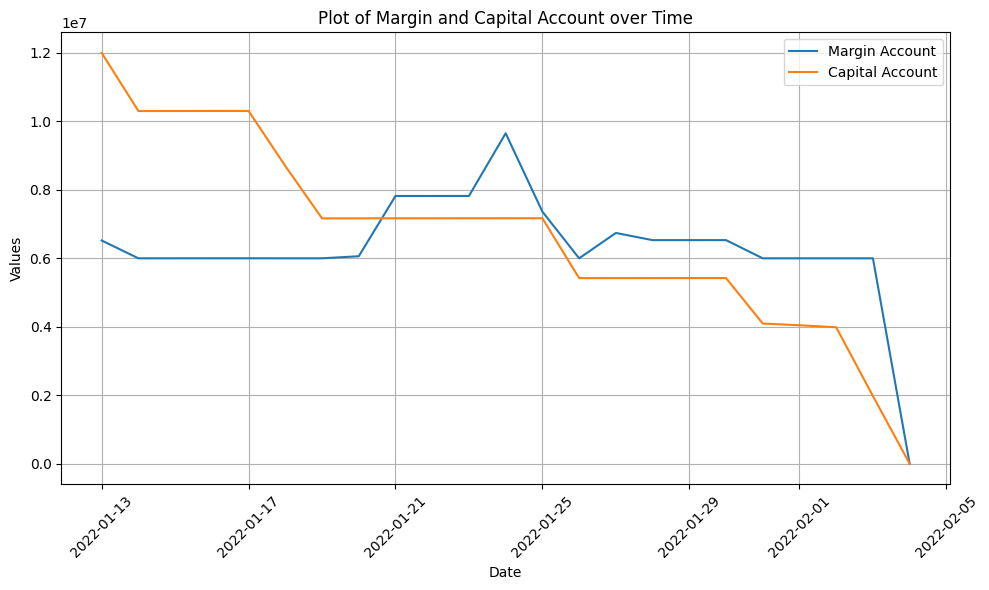

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(records['Date'], records['Margin Account'], label='Margin Account')
plt.plot(records['Date'], records['Capital Account'], label='Capital Account')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Plot of Margin and Capital Account over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Conclusion


As the capital account of the company is not enough to perform the margin call on the Feb 4th, 2022, the company has to take all of the capital account left to pay for the margin call and announce bankrupt. Since then, the company will not be able to live until the forward contract maturity. Hence, the final capital account is 0.


### c.


#### Setup


In [21]:
enter_date = date(2022, 1, 12)
settle_price = 78
total_barrel = 1000000
barrel_per_contract = 1000
settle_date = date(2023, 12, 8)
total_contract = 1000
capital_account = 18000000
capital_interest = 0.03
days_per_year = 365

#### Calculation


In [22]:
capital = capital_account
spot_price = cushing[(cushing['Date'].dt.date==settle_date)]['Price'].reset_index(drop=True).at[0]
payoff_from_forward = (spot_price - settle_price)*total_barrel
capital *= math.exp(capital_interest*(settle_date-enter_date).days/365)
capital += payoff_from_forward
print('Payoff from forward contract:', payoff_from_forward)
print('Net final capital account:', capital)

Payoff from forward contract: -7129999.999999995
Net final capital account: 11928154.077718657


#### Conclusion


- The company make a lost in forward contract of: 7130000
- The company final capital account: 11928154.077718657


### d.


From the above questions, we can see that:

- In question a, the hedging decision of the company is correct as it backup the lost from the forward contract
- In question b, however, the company does not take the liquidity of the future contract into account. As the result, we can see that the company is out of fund and can not survive to realise the profit from the hedge. It has to annouce bankrupt due to the requirement of the daily settlement of the future contract
- In question c, we can see that if there is no future contract, the company will directly face the lost from the forward contract as it is not hedged like question a.
- In summary, we can see that hedging is a good practice for company but it not totally correct if we does not take the liquidity into account. We must take on consideration for the requirement to survive of the hedge as well, not only focusing on the optimal hedge only
